In [1]:
print("starting script")


import os, sys
import h5py
import numpy as np
import pandas as pd
import scipy
import math as m
import cmath
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from pprint import pprint
import json



PROJECT_CWD = r"/workspace/"
sys.path.append(PROJECT_CWD)

os.chdir(PROJECT_CWD)
os.environ['GIT_PYTHON_REFRESH'] = 'quiet'
os.environ["MLFLOW_TRACKING_URI"] = "mlflow"

from my_packages.neural_network.data_generators.mixed_array_generator import MixedArrayGenerator
from my_packages.neural_network.data_generators.array_generator_mag_and_phase import ArrayGenerator_MagnitudesAndPhases
from my_packages.neural_network.data_generators.iterator import DataIterator
from my_packages.neural_network.model.model_trainers.dipole_position_trainer import Trainer
from my_packages.neural_network.model.model_base import Model_Base

# torch import
import torch
from torch.utils.data import TensorDataset, DataLoader

print("cuda available: ", torch.cuda.is_available())
print("number of GPUs: ",torch.cuda.device_count())
print("I am currently using device number: ", torch.cuda.current_device())
print("the device object is: ", torch.cuda.device(0))
print("the device name is: ", torch.cuda.get_device_name(0))
torch.cuda.empty_cache()


from my_packages.neural_network.model.early_stopping import EarlyStopping


# consider the GPU
from my_packages.neural_network.gpu_aux import get_default_device, to_device, DeviceDataLoader
from torchsummary import summary

from torch import nn
import torch.nn.functional as F
from my_packages.neural_network.datasets_and_loaders.dataset_transformers_multilayer import H_Components_Dataset_Multilayer
from my_packages.neural_network.datasets_and_loaders.dataset_transformers_E import E_Components_Dataset

from singleton_python_objects.mixed_array_generator import get_mixed_array_generator
from NN_model_architectures.PredictDipolePosition.ResNet import get_model

starting script
cuda available:  True
number of GPUs:  1
I am currently using device number:  0
the device object is:  <torch.cuda.device object at 0x7f788847ba30>
the device name is:  NVIDIA T600 Laptop GPU


In [2]:
data_dir = "/ext_data/NN_data/11_res_noise_MP_labels/"

# load the data properties
json_file = os.path.join(data_dir, "data_properties.json")
with open(json_file, "r") as f:
    properties = json.load(f)

properties["probe_height"] = [6e-3, 8e-3, 1e-2, 1.2e-2]


# rmg = MixedArrayGenerator(**properties)
rmg_dp = ArrayGenerator_MagnitudesAndPhases(
    **properties,
    )

# rmg = get_mixed_array_generator()
data_iterator = DataIterator(rmg_dp)


fields,labels = data_iterator.generate_N_data_samples(10)



Generating data:   0%|          | 0/10 [00:00<?, ?samples/s]

Generating data: 100%|██████████| 10/10 [00:04<00:00,  2.24samples/s]


finished initializing


(<Figure size 1000x1000 with 16 Axes>,
 array([[<Axes: title={'center': 'Hx - X Component Magnitude'}, xlabel='X [mm]', ylabel='Y [mm]'>,
         <Axes: title={'center': 'Hy - Y Component Magnitude'}, xlabel='X [mm]', ylabel='Y [mm]'>],
        [<Axes: title={'center': 'Hx'}, xlabel='x (mm)', ylabel='y (mm)'>,
         <Axes: title={'center': 'Hy'}, xlabel='x (mm)', ylabel='y (mm)'>],
        [<Axes: title={'center': 'Hx Phase sin'}, xlabel='x (mm)', ylabel='y (mm)'>,
         <Axes: title={'center': 'Hy Phase sin'}, xlabel='x (mm)', ylabel='y (mm)'>],
        [<Axes: title={'center': 'Hx Phase cos'}, xlabel='x (mm)', ylabel='y (mm)'>,
         <Axes: title={'center': 'Hy Phase cos'}, xlabel='x (mm)', ylabel='y (mm)'>]],
       dtype=object))

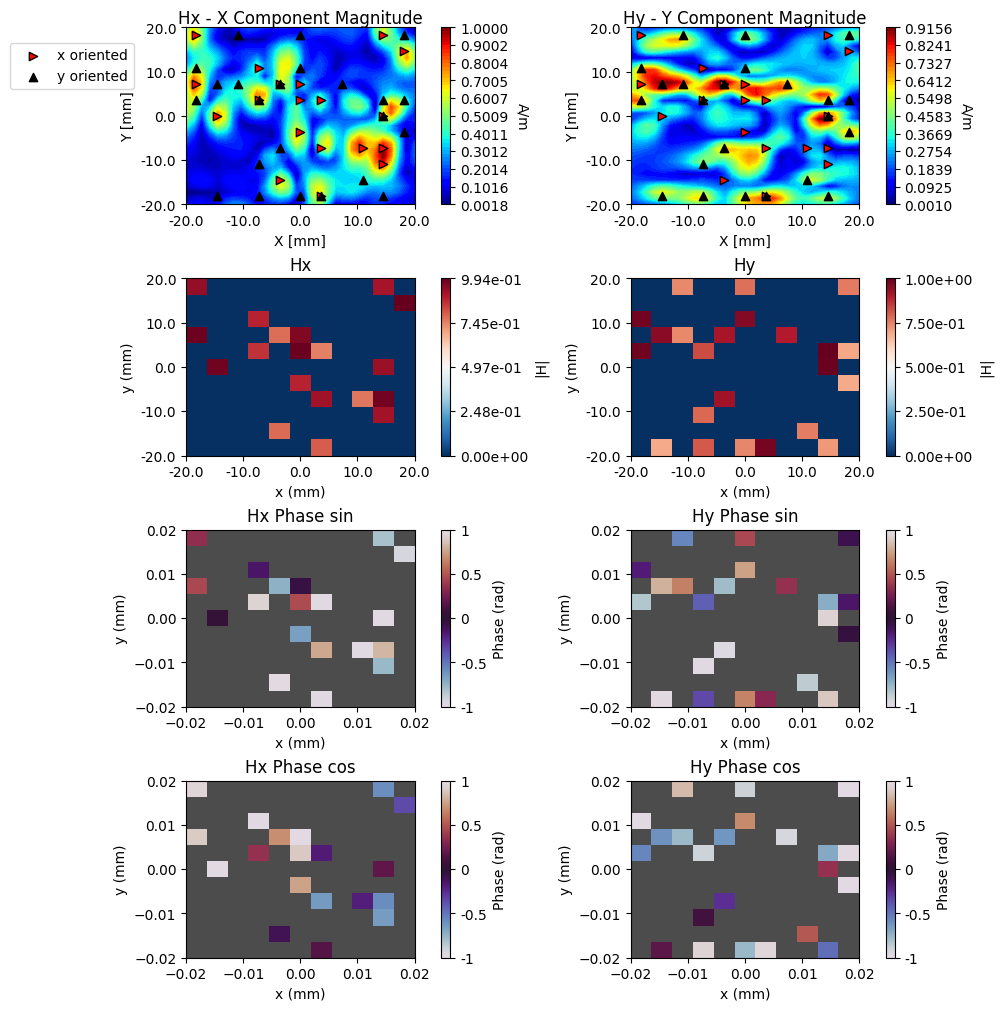

In [3]:
%matplotlib inline
f, t = fields[0], labels[0]

height_index = 0

ds = TensorDataset(torch.from_numpy(fields), torch.from_numpy(labels))
# Eds = E_Components_Dataset(ds, probe_height_index=height_index).scale_to_01()
Hds = H_Components_Dataset_Multilayer(ds).rescale_probe_heights().rescale_labels().expand_phase()

fH, lH = Hds[0]

# rmg_dp.plot_target_magnitude(lH)
# rmg_dp.plot_target_phase(lH, normalized01=True)
fig, ax = plt.subplots(4,2, figsize=(10,10), constrained_layout=True)
rmg_dp.plot(fH, lH, index=height_index, ax=ax)

## Define the model

In [9]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from my_packages.neural_network.model.model_base import Model_Base
from NN_model_architectures.NN_blocks import simple_conv_block, conv_block, linear_block

from torchsummary import summary
from torchviz import make_dot

 
class Convolutional_Base(nn.Module):
    def __init__(
            self, input_shape, output_shape):
        super(Convolutional_Base, self).__init__()
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.n_layers = self.input_shape[0]
        self.out_size = np.prod(output_shape)

        self.conv1 = simple_conv_block(self.n_layers, 64)
        self.res1 = conv_block(64, n=2)

        self.conv2 = nn.Sequential(
            simple_conv_block(64, 128),
            nn.MaxPool2d(2)
            )
        
        self.res2 = conv_block(128, n=2)

        self.conv3 = nn.Sequential(
            simple_conv_block(128, 256),
            nn.MaxPool2d(2)
            )
        self.res3 = conv_block(256, n=2)
        self.global_pool = nn.Sequential(
            simple_conv_block(256, 256),
            nn.AdaptiveMaxPool2d((1,1))
            )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.res1(x) + x
        x = self.conv2(x)
        x = self.res2(x) + x
        x = self.conv3(x)
        x = self.res3(x) + x
        x = self.global_pool(x)
        return x
    
class BinaryPredictionHead(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(BinaryPredictionHead, self).__init__()
        self.input_shape = input_shape
        self.output_shape = output_shape

        self.output_size = np.prod(output_shape)

        self.dropout3 = nn.Dropout(0.05)
        self.fc1 = linear_block(256, 512)
        self.dropout4 = nn.Dropout(0.05)
        self.fc2 = linear_block(512, self.output_size, activation=None)
        
    def forward(self, x):
        if len(x.shape) > 2:
            x = x.view(x.shape[0], -1)
        x = self.dropout3(x)
        x = self.fc1(x)
        x = self.dropout4(x)
        x = self.fc2(x)
        return x
    
class DipoleMagnitudePredictionHead(nn.Module):
    def __init__(self, input_shape, output_shape, binary_output_shape):
        super(DipoleMagnitudePredictionHead, self).__init__()
        self.input_shape = input_shape
        self.output_shape = output_shape

        self.output_size = np.prod(output_shape)
        self.binary_output_size = np.prod(binary_output_shape)

        self.dropout3 = nn.Dropout(0.05)
        self.fc1 = linear_block(self.binary_output_size + 256, 512) # Modify here
        self.dropout4 = nn.Dropout(0.05)
        self.fc2 = linear_block(512, 512)
        self.dropout5 = nn.Dropout(0.05)
        self.fc3 = linear_block(512, self.output_size, activation=nn.ReLU())

    def forward(self, x, binary_label): # Accept binary_label as input
        if len(x.shape) > 2:
            x = x.view(x.shape[0], -1)
        if len(binary_label.shape) > 2:
            binary_label = binary_label.view(binary_label.shape[0], -1)
        x = torch.cat((x, binary_label), dim=1) # Concatenate along the feature dimension
        x = self.dropout3(x)
        x = self.fc1(x)
        x = self.dropout4(x)
        x = self.fc2(x)
        x = self.dropout5(x)
        x = self.fc3(x)
        return x



class myModel(Model_Base):
    def __init__(self, input_shape, output_shape, binary_output_shape):
        super(myModel, self).__init__()
        self.input_shape = input_shape
        self.output_shape = output_shape

        self.conv_base = Convolutional_Base(input_shape, 256)
        self.pred_head = BinaryPredictionHead(256, binary_output_shape)
        self.magntiude_head = DipoleMagnitudePredictionHead(256, output_shape, binary_output_shape)

    def forward(self, x, binary_labels=None):
        conv_output = self.conv_base(x)
        binary_prediction = self.pred_head(conv_output)
        
        if binary_labels is None:
            # Only during inference
            binary_labels = torch.sigmoid(binary_prediction)
        
        magnitude_prediction = self.magntiude_head(conv_output, binary_labels)
        return binary_prediction, magnitude_prediction
        
        
    
    
input_shape = (3,30,30)
output_shape = (2,30,30)
binary_output_shape = (2,30,30)

model = myModel(input_shape, output_shape, binary_output_shape)
onnx_path = "onnx_models/myModel.onnx"
model.export_to_onnx(onnx_path)

to_device(model, torch.device('cuda'))
summary(model, input_shape)



================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           1,792
              ReLU-2           [-1, 64, 30, 30]               0
            Conv2d-3           [-1, 64, 30, 30]          36,928
              ReLU-4           [-1, 64, 30, 30]               0
            Conv2d-5           [-1, 64, 30, 30]          36,928
              ReLU-6           [-1, 64, 30, 30]               0
       BatchNorm2d-7           [-1, 64, 30, 30]             128
            Conv2d-8          [-1, 128, 30, 30]          73,856
              ReLU-9          [-1, 128, 30, 30]               0
        MaxPool2d-10          [-1, 128, 15, 15]               0
           Conv2d-11         

## Data Loaders

In [10]:
fullpath_train = os.path.join(data_dir, "training.pt")
fullpath_test = os.path.join(data_dir, "test.pt")


# load the data from the datasets
train_and_valid_dataset = torch.load(fullpath_train)
test_dataset = torch.load(fullpath_test)

In [12]:
Hds = H_Components_Dataset_Multilayer(train_and_valid_dataset)

train_size = int(0.8 * len(Hds))
val_size = len(Hds) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(Hds, [train_size, val_size])

finished initializing


In [14]:
f, l = Hds[0]

In [15]:
f.shape

torch.Size([2, 3, 30, 30])